In [ ]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-17 15:54:53--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  13.8MB/s    in 7.8s    

2024-08-17 15:55:01 (13.4 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [ ]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [ ]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 22.61it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 18.00%
Epoch 1, Val Loss: 2.115, Val Accuracy: 33.00%


100%|██████████| 16/16 [00:00<00:00, 22.39it/s]


Epoch 2, Train Loss: 1.868, Train Accuracy: 40.60%
Epoch 2, Val Loss: 1.487, Val Accuracy: 51.40%


100%|██████████| 16/16 [00:00<00:00, 23.00it/s]


Epoch 3, Train Loss: 1.242, Train Accuracy: 58.30%
Epoch 3, Val Loss: 0.825, Val Accuracy: 75.40%


100%|██████████| 16/16 [00:00<00:00, 22.74it/s]


Epoch 4, Train Loss: 0.750, Train Accuracy: 75.50%
Epoch 4, Val Loss: 0.516, Val Accuracy: 83.60%


100%|██████████| 16/16 [00:00<00:00, 22.79it/s]


Epoch 5, Train Loss: 0.488, Train Accuracy: 85.00%
Epoch 5, Val Loss: 0.429, Val Accuracy: 86.00%
Treinamento concluído


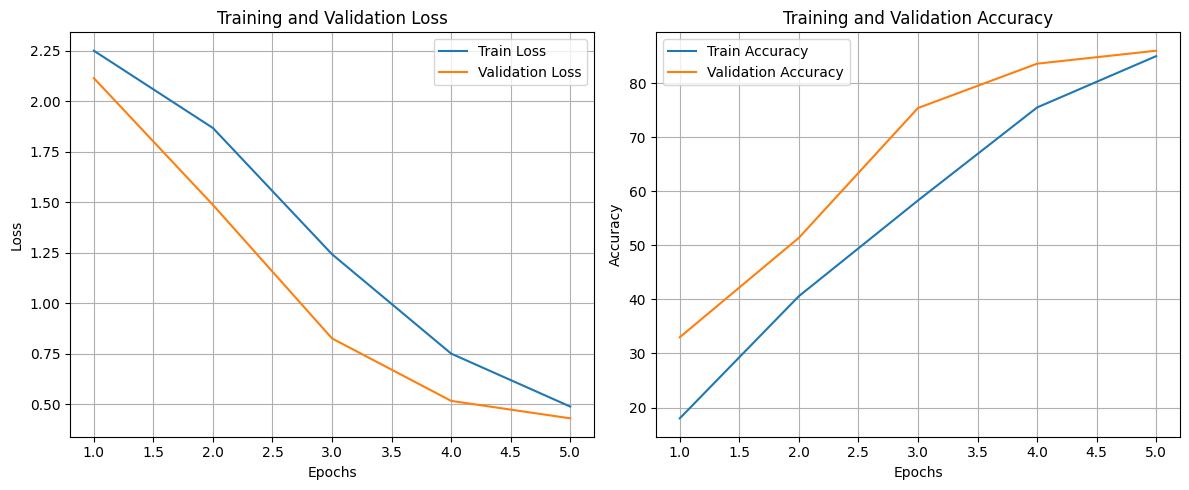

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 78.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2,num_filters_1=6,num_filters_2=12):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
# Modelo 6 e 16
model_2 = CNN(initialize_weights=True, dropout=0.2, num_filters_1=6 , num_filters_2=16)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history2 = train_model(
    model=model_2,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

# Modelo 8 e 12

model_3 = CNN(initialize_weights=True, dropout=0.2, num_filters_1=8 , num_filters_2=12)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_3.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history3 = train_model(
    model=model_3,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

# Modelo 8 e 16

model_4 = CNN(initialize_weights=True, dropout=0.2, num_filters_1=8 , num_filters_2=16)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_4.parameters(), lr=0.01, momentum=0.9)

# Treinando a CNN
history4 = train_model(
    model=model_4,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:00<00:00, 22.93it/s]


Epoch 1, Train Loss: 2.266, Train Accuracy: 15.60%
Epoch 1, Val Loss: 2.124, Val Accuracy: 38.80%


100%|██████████| 16/16 [00:00<00:00, 22.69it/s]


Epoch 2, Train Loss: 1.876, Train Accuracy: 42.60%
Epoch 2, Val Loss: 1.461, Val Accuracy: 52.20%


100%|██████████| 16/16 [00:00<00:00, 22.29it/s]


Epoch 3, Train Loss: 1.215, Train Accuracy: 59.10%
Epoch 3, Val Loss: 0.717, Val Accuracy: 77.00%


100%|██████████| 16/16 [00:00<00:00, 22.66it/s]


Epoch 4, Train Loss: 0.696, Train Accuracy: 76.60%
Epoch 4, Val Loss: 0.486, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 22.90it/s]


Epoch 5, Train Loss: 0.507, Train Accuracy: 83.10%
Epoch 5, Val Loss: 0.382, Val Accuracy: 87.80%
Treinamento concluído


100%|██████████| 16/16 [00:00<00:00, 22.43it/s]


Epoch 1, Train Loss: 2.265, Train Accuracy: 15.90%
Epoch 1, Val Loss: 2.154, Val Accuracy: 30.00%


100%|██████████| 16/16 [00:00<00:00, 22.12it/s]


Epoch 2, Train Loss: 1.909, Train Accuracy: 36.30%
Epoch 2, Val Loss: 1.468, Val Accuracy: 53.20%


100%|██████████| 16/16 [00:00<00:00, 22.34it/s]


Epoch 3, Train Loss: 1.164, Train Accuracy: 60.70%
Epoch 3, Val Loss: 0.742, Val Accuracy: 76.20%


100%|██████████| 16/16 [00:00<00:00, 16.42it/s]


Epoch 4, Train Loss: 0.720, Train Accuracy: 75.40%
Epoch 4, Val Loss: 0.569, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:01<00:00, 15.08it/s]


Epoch 5, Train Loss: 0.518, Train Accuracy: 81.80%
Epoch 5, Val Loss: 0.433, Val Accuracy: 85.20%
Treinamento concluído


100%|██████████| 16/16 [00:01<00:00, 15.48it/s]


Epoch 1, Train Loss: 2.281, Train Accuracy: 16.20%
Epoch 1, Val Loss: 2.153, Val Accuracy: 23.40%


100%|██████████| 16/16 [00:00<00:00, 22.18it/s]


Epoch 2, Train Loss: 1.881, Train Accuracy: 39.90%
Epoch 2, Val Loss: 1.414, Val Accuracy: 60.60%


100%|██████████| 16/16 [00:00<00:00, 22.62it/s]


Epoch 3, Train Loss: 1.135, Train Accuracy: 60.10%
Epoch 3, Val Loss: 0.689, Val Accuracy: 78.60%


100%|██████████| 16/16 [00:00<00:00, 22.48it/s]


Epoch 4, Train Loss: 0.686, Train Accuracy: 76.00%
Epoch 4, Val Loss: 0.501, Val Accuracy: 83.60%


100%|██████████| 16/16 [00:00<00:00, 22.49it/s]


Epoch 5, Train Loss: 0.496, Train Accuracy: 82.20%
Epoch 5, Val Loss: 0.408, Val Accuracy: 88.80%
Treinamento concluído


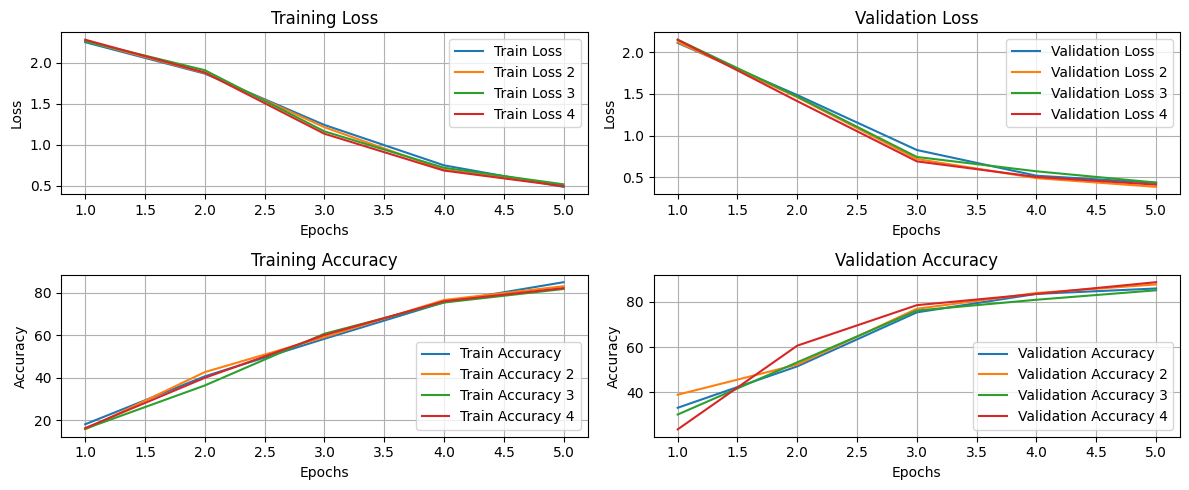

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de train losses
plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history2['train_losses'], label='Train Loss 2')
plt.plot(epochs, history3['train_losses'], label='Train Loss 3')
plt.plot(epochs, history4['train_losses'], label='Train Loss 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot de validation losses

plt.subplot(2, 2, 2)
plt.grid()
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.plot(epochs, history2['val_losses'], label='Validation Loss 2')
plt.plot(epochs, history3['val_losses'], label='Validation Loss 3')
plt.plot(epochs, history4['val_losses'], label='Validation Loss 4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()


# Plot de train accuracies
plt.subplot(2, 2, 3)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history2['train_accuracies'], label='Train Accuracy 2')
plt.plot(epochs, history3['train_accuracies'], label='Train Accuracy 3')
plt.plot(epochs, history4['train_accuracies'], label='Train Accuracy 4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

# Plot de validation accuracies
plt.subplot(2, 2, 4)
plt.grid()
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.plot(epochs, history2['val_accuracies'], label='Validation Accuracy 2')
plt.plot(epochs, history3['val_accuracies'], label='Validation Accuracy 3')
plt.plot(epochs, history4['val_accuracies'], label='Validation Accuracy 4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [ ]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2,num_filters_1=6,num_filters_2=12, num_neurons=64):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [ ]:
for i in range(5):
     num_neurons = np.random.randint(10, 100)
     model = CNN(initialize_weights=True, dropout=0.2, num_neurons=num_neurons)
     criterion = nn.CrossEntropyLoss()
     optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
     history = train_model(model=model, trainloader=trainloader, valloader=valloader, criterion=criterion, optimizer=optimizer)

     print(f'Número de neurônios na camada fully connected: {num_neurons}')
     test_model(model, testloader)
     print('---------------------------------\n')

100%|██████████| 16/16 [00:00<00:00, 23.46it/s]


Epoch 1, Train Loss: 2.307, Train Accuracy: 16.50%
Epoch 1, Val Loss: 2.177, Val Accuracy: 33.00%


100%|██████████| 16/16 [00:00<00:00, 22.45it/s]


Epoch 2, Train Loss: 1.999, Train Accuracy: 34.00%
Epoch 2, Val Loss: 1.569, Val Accuracy: 55.00%


100%|██████████| 16/16 [00:00<00:00, 23.22it/s]


Epoch 3, Train Loss: 1.304, Train Accuracy: 55.70%
Epoch 3, Val Loss: 0.814, Val Accuracy: 71.40%


100%|██████████| 16/16 [00:00<00:00, 22.96it/s]


Epoch 4, Train Loss: 0.825, Train Accuracy: 69.90%
Epoch 4, Val Loss: 0.563, Val Accuracy: 82.60%


100%|██████████| 16/16 [00:00<00:00, 16.97it/s]


Epoch 5, Train Loss: 0.592, Train Accuracy: 81.80%
Epoch 5, Val Loss: 0.482, Val Accuracy: 84.20%
Treinamento concluído
Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 87.00%




100%|██████████| 16/16 [00:01<00:00, 15.17it/s]


Epoch 1, Train Loss: 2.256, Train Accuracy: 18.50%
Epoch 1, Val Loss: 2.105, Val Accuracy: 36.80%


100%|██████████| 16/16 [00:00<00:00, 20.94it/s]


Epoch 2, Train Loss: 1.849, Train Accuracy: 41.70%
Epoch 2, Val Loss: 1.287, Val Accuracy: 69.60%


100%|██████████| 16/16 [00:00<00:00, 17.01it/s]


Epoch 3, Train Loss: 1.111, Train Accuracy: 63.30%
Epoch 3, Val Loss: 0.643, Val Accuracy: 79.40%


100%|██████████| 16/16 [00:01<00:00, 15.75it/s]


Epoch 4, Train Loss: 0.718, Train Accuracy: 77.00%
Epoch 4, Val Loss: 0.504, Val Accuracy: 84.80%


100%|██████████| 16/16 [00:00<00:00, 17.85it/s]


Epoch 5, Train Loss: 0.525, Train Accuracy: 83.60%
Epoch 5, Val Loss: 0.413, Val Accuracy: 87.00%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 88.40%




100%|██████████| 16/16 [00:00<00:00, 22.38it/s]


Epoch 1, Train Loss: 2.216, Train Accuracy: 18.60%
Epoch 1, Val Loss: 2.056, Val Accuracy: 37.80%


100%|██████████| 16/16 [00:00<00:00, 22.59it/s]


Epoch 2, Train Loss: 1.675, Train Accuracy: 52.70%
Epoch 2, Val Loss: 0.989, Val Accuracy: 75.20%


100%|██████████| 16/16 [00:00<00:00, 22.15it/s]


Epoch 3, Train Loss: 0.849, Train Accuracy: 72.30%
Epoch 3, Val Loss: 0.531, Val Accuracy: 84.40%


100%|██████████| 16/16 [00:00<00:00, 21.97it/s]


Epoch 4, Train Loss: 0.535, Train Accuracy: 82.60%
Epoch 4, Val Loss: 0.467, Val Accuracy: 85.60%


100%|██████████| 16/16 [00:00<00:00, 20.85it/s]


Epoch 5, Train Loss: 0.403, Train Accuracy: 87.50%
Epoch 5, Val Loss: 0.397, Val Accuracy: 88.40%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 91.40%




100%|██████████| 16/16 [00:00<00:00, 16.50it/s]


Epoch 1, Train Loss: 2.282, Train Accuracy: 15.60%
Epoch 1, Val Loss: 2.188, Val Accuracy: 30.40%


100%|██████████| 16/16 [00:01<00:00, 12.13it/s]


Epoch 2, Train Loss: 2.015, Train Accuracy: 32.20%
Epoch 2, Val Loss: 1.725, Val Accuracy: 46.00%


100%|██████████| 16/16 [00:01<00:00, 13.97it/s]


Epoch 3, Train Loss: 1.492, Train Accuracy: 49.80%
Epoch 3, Val Loss: 1.084, Val Accuracy: 68.00%


100%|██████████| 16/16 [00:00<00:00, 23.65it/s]


Epoch 4, Train Loss: 0.866, Train Accuracy: 71.20%
Epoch 4, Val Loss: 0.550, Val Accuracy: 83.80%


100%|██████████| 16/16 [00:00<00:00, 23.12it/s]


Epoch 5, Train Loss: 0.549, Train Accuracy: 81.70%
Epoch 5, Val Loss: 0.442, Val Accuracy: 85.60%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 89.20%




100%|██████████| 16/16 [00:00<00:00, 22.84it/s]


Epoch 1, Train Loss: 2.257, Train Accuracy: 14.50%
Epoch 1, Val Loss: 2.137, Val Accuracy: 24.20%


100%|██████████| 16/16 [00:00<00:00, 22.72it/s]


Epoch 2, Train Loss: 1.988, Train Accuracy: 31.80%
Epoch 2, Val Loss: 1.691, Val Accuracy: 52.80%


100%|██████████| 16/16 [00:00<00:00, 22.66it/s]


Epoch 3, Train Loss: 1.554, Train Accuracy: 46.80%
Epoch 3, Val Loss: 1.225, Val Accuracy: 65.20%


100%|██████████| 16/16 [00:00<00:00, 22.08it/s]


Epoch 4, Train Loss: 1.206, Train Accuracy: 58.50%
Epoch 4, Val Loss: 0.835, Val Accuracy: 74.80%


100%|██████████| 16/16 [00:00<00:00, 22.60it/s]


Epoch 5, Train Loss: 0.879, Train Accuracy: 70.60%
Epoch 5, Val Loss: 0.588, Val Accuracy: 81.60%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 84.80%


